In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


In [2]:
%load_ext autoreload
%autoreload 2

from simulator.load_data import load_md_from_file
from simulator.simulator import Sim
from simulator.strategy import StoikovStrategy, BestPosStrategy, FutureMidPriceStrategy


In [3]:
md = load_md_from_file(path='md/btcusdt_Binance_LinearPerpetual/', nrows=10 ** 5)
latency = pd.Timedelta(10, 'ms').delta
md_latency = pd.Timedelta(10, 'ms').delta

delay = pd.Timedelta(0.1, 's').delta
hold_time = pd.Timedelta(10, 's').delta

C:\Users\Rs63\AppData\Local\Temp\ipykernel_1868\437147249.py:2: FutureWarning: Timedelta.delta is deprecated and will be removed in a future version.
  latency = pd.Timedelta(10, 'ms').delta
C:\Users\Rs63\AppData\Local\Temp\ipykernel_1868\437147249.py:3: FutureWarning: Timedelta.delta is deprecated and will be removed in a future version.
  md_latency = pd.Timedelta(10, 'ms').delta
C:\Users\Rs63\AppData\Local\Temp\ipykernel_1868\437147249.py:5: FutureWarning: Timedelta.delta is deprecated and will be removed in a future version.
  delay = pd.Timedelta(0.1, 's').delta
C:\Users\Rs63\AppData\Local\Temp\ipykernel_1868\437147249.py:6: FutureWarning: Timedelta.delta is deprecated and will be removed in a future version.
  hold_time = pd.Timedelta(10, 's').delta


In [71]:
gamma = 1
horizon_const = 1
intensity = 3

sim = Sim(md, latency, md_latency)
stoikov = StoikovStrategy(delay, gamma, horizon_const, intensity)
res = stoikov.run(sim)

In [72]:
sim = Sim(md, latency, md_latency)
mid_price = BestPosStrategy(delay)
res = mid_price.run(sim)

In [105]:
sim = Sim(md, latency, md_latency)
future = FutureMidPriceStrategy(delay, md)
res = future.run(sim)

Сравним графики PnL трех стратегий:

Text(0, 0.5, 'PNL')

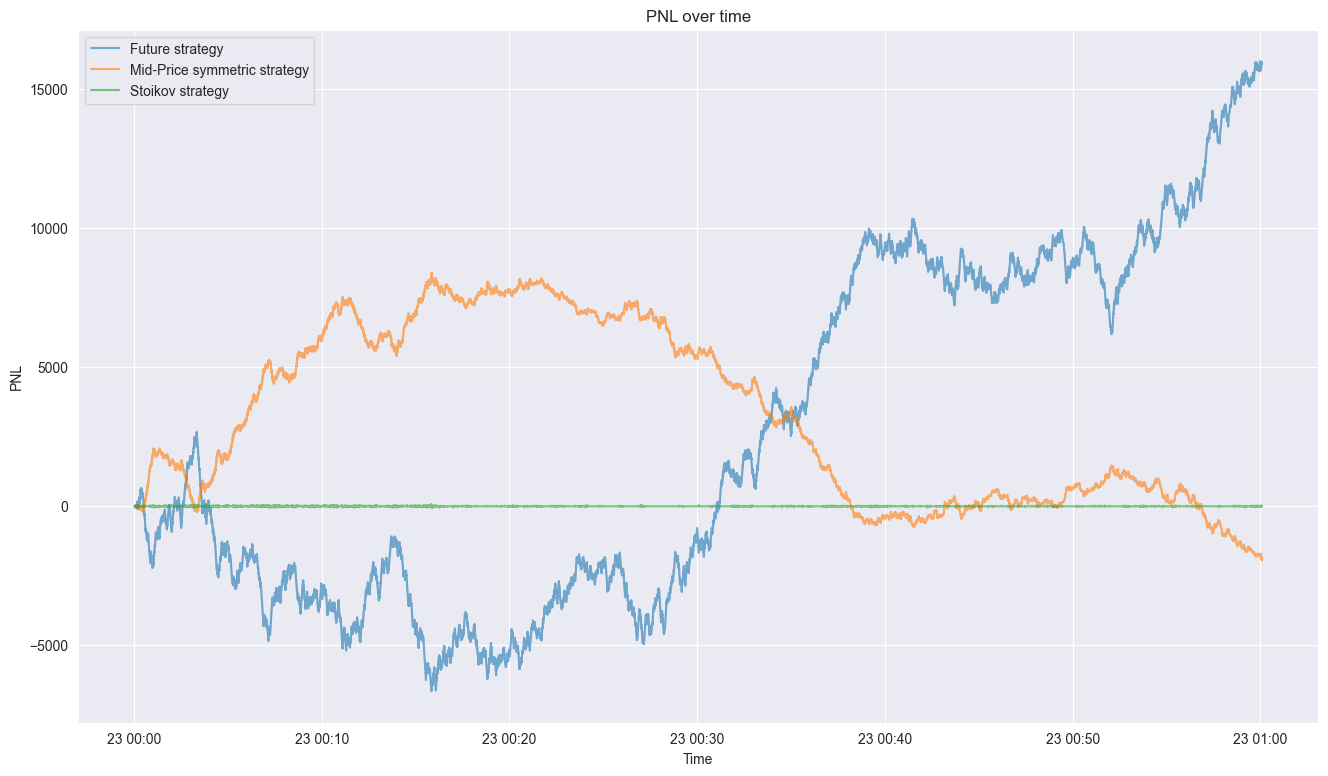

In [107]:
sns.set_style('darkgrid')
plt.figure(figsize=(16, 9))
plt.title('PNL over time')
plt.plot(future.history['time'], future.history['pnl'][1:], label='Future strategy', alpha=0.6)
plt.plot(mid_price.history['time'], mid_price.history['pnl'][1:], label='Mid-Price symmetric strategy',
         alpha=0.6)
plt.plot(stoikov.history['time'], stoikov.history['pnl'][1:], label='Stoikov strategy', alpha=0.6)
plt.legend()
plt.xlabel('Time')
plt.ylabel('PNL')

In [108]:
print('Средние значения PnL:\nStoikov strategy: {}\nMid-Price strategy: {}\nFuture strategy: {}'.format(np.mean(stoikov.history['pnl'][1:]), np.mean(mid_price.history['pnl'][1:]), np.mean(future.history['pnl'][1:])))

Средние значения PnL:
Stoikov strategy: -0.6932034096562018
Mid-Price strategy: 3786.817827198352
Future strategy: 308.4222039930267


In [109]:
print('Стандартное отклонение PnL:\nStoikov strategy: {}\nMid-Price strategy: {}\nFuture strategy: {}'.format(np.std(stoikov.history['pnl'][1:]), np.std(mid_price.history['pnl'][1:]), np.std(future.history['pnl'][1:])))

Стандартное отклонение PnL:
Stoikov strategy: 7.49546987168286
Mid-Price strategy: 3026.7401906608993
Future strategy: 5557.9138181852595


Видим, что стандартное отклоние PnL у стратегии Стойкова гораздо ниже, чем у двух других стратегий.

Сравним спреды стратегий:

Text(0.5, 1.0, 'Spreads')

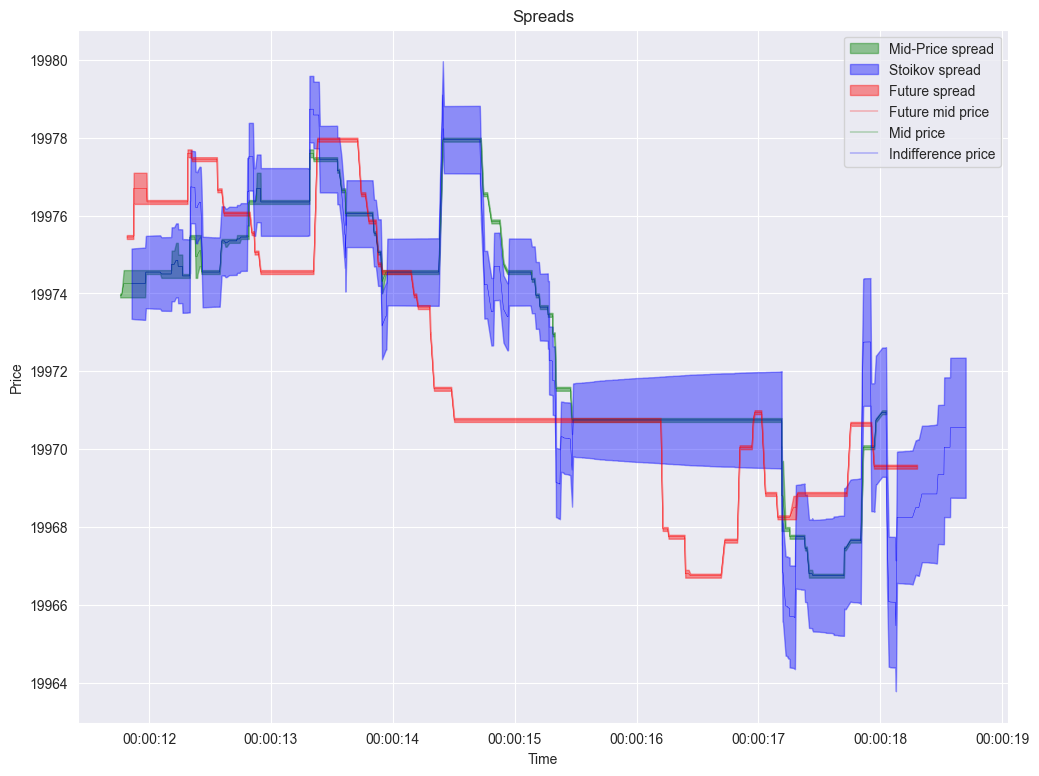

In [128]:
plt.figure(figsize=(12, 9))

plt.fill_between(mid_price.history['time'][1000:2000], mid_price.history['bid_price'][1000:2000],
                 mid_price.history['ask_price'][1000:2000], label='Mid-Price spread', alpha=0.4, color='green')
plt.fill_between(stoikov.history['time'][1000:2000], stoikov.history['bid_price'][1000:2000],
                 stoikov.history['ask_price'][1000:2000], label='Stoikov spread', alpha=0.4, color='blue')
plt.fill_between(future.history['time'][1000:2000], future.history['bid_price'][1000:2000], future.history['ask_price'][1000:2000],
                 label='Future spread', alpha=0.4, color='red')
plt.plot(future.history['time'][1000:2000], future.history['mid_price'][1000:2000], label='Future mid price',
         color='red', linewidth=0.3)
plt.plot(mid_price.history['time'][1000:2000], mid_price.history['mid_price'][1000:2000], label='Mid price',
         color='green', linewidth=0.3)
plt.plot(stoikov.history['time'][1000:2000], stoikov.history['indifference_price'][1000:2000], label='Indifference price',
         color='blue', linewidth=0.3)
plt.legend()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Spreads')

Графики получились слишком дискретные и некрасивые, но можно сделать вывод, что у стратегии Стойкова спред шире, чем у других.

In [129]:
stoikov_spread = np.array(stoikov.history['ask_price']) - np.array(stoikov.history['bid_price'])
mid_spread = np.array(mid_price.history['ask_price']) - np.array(mid_price.history['bid_price'])
future_spread = np.array(future.history['ask_price']) - np.array(future.history['bid_price'])

Text(0, 0.5, 'Spread')

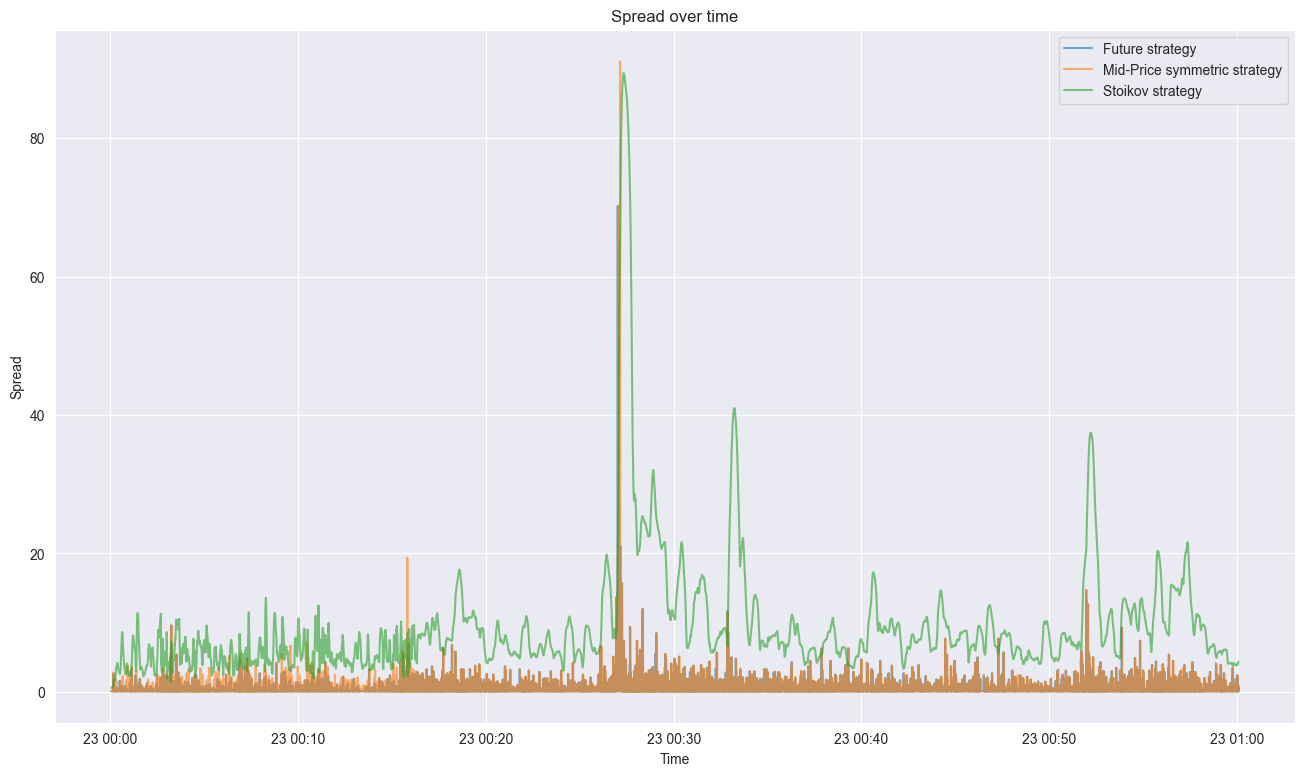

In [130]:
plt.figure(figsize=(16, 9))
plt.title('Spread over time')
plt.plot(future.history['time'], future_spread, label='Future strategy', alpha=0.6)
plt.plot(mid_price.history['time'], mid_spread, label='Mid-Price symmetric strategy',
         alpha=0.6)
plt.plot(stoikov.history['time'], stoikov_spread, label='Stoikov strategy', alpha=0.6)
plt.legend()
plt.xlabel('Time')
plt.ylabel('Spread')

Спред у стратегии стойкова больше, чем у мид-прайс стратегий

Сравним inventory стратегий в биткоинах:

Text(0, 0.5, 'Inventory')

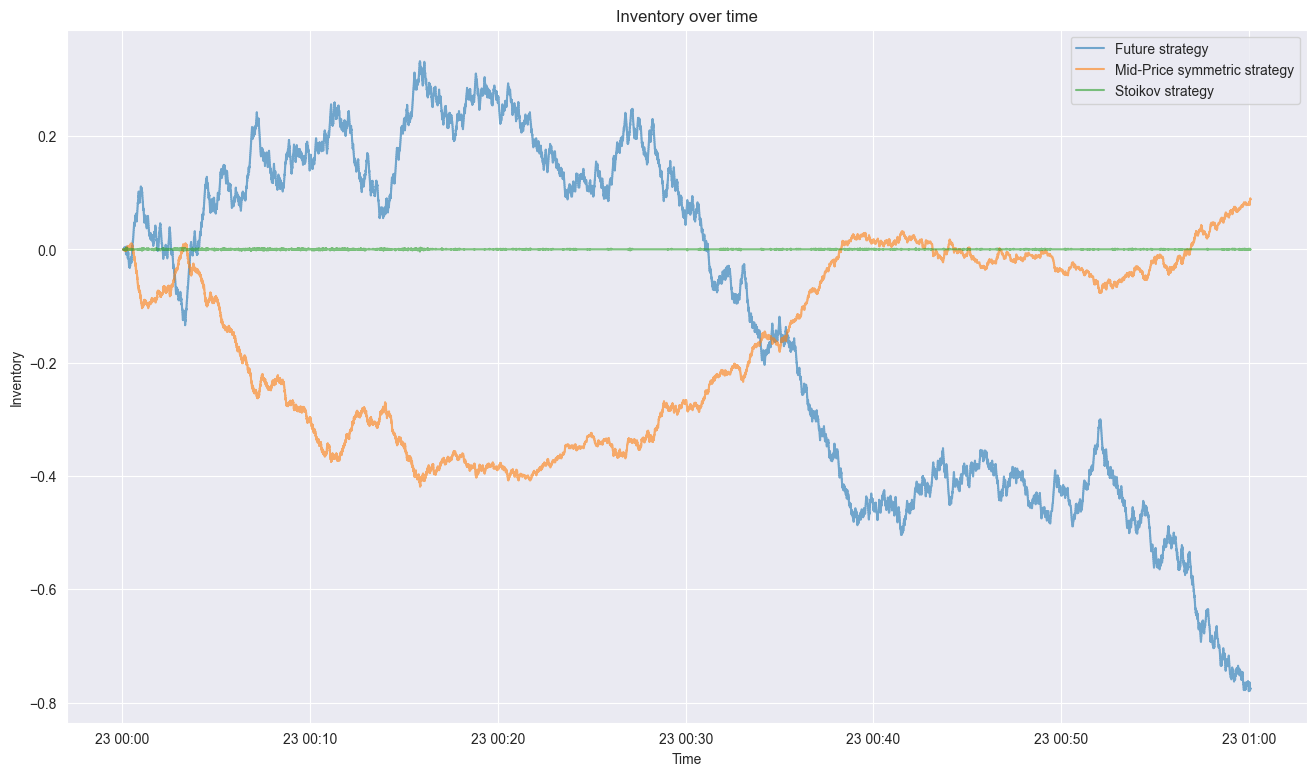

In [113]:
plt.figure(figsize=(16, 9))
plt.title('Inventory over time')
plt.plot(future.history['time'], future.history['inventory'], label='Future strategy', alpha=0.6)
plt.plot(mid_price.history['time'], mid_price.history['inventory'], label='Mid-Price symmetric strategy',
         alpha=0.6)
plt.plot(stoikov.history['time'], stoikov.history['inventory'], label='Stoikov strategy', alpha=0.6)
plt.legend()
plt.xlabel('Time')
plt.ylabel('Inventory')

In [114]:
print('Стандартное отклонение Inventory:\nStoikov strategy: {}\nMid-Price strategy: {}\nFuture strategy: {}'.format(np.std(stoikov.history['inventory'][1:]), np.std(mid_price.history['inventory'][1:]), np.std(future.history['inventory'][1:])))

Стандартное отклонение Inventory:
Stoikov strategy: 0.00037294215582395565
Mid-Price strategy: 0.1498382495866861
Future strategy: 0.27296838849879673


Дисперсия размера портфеля у стратегии Стойкова оказалась ниже, чем у других стратегий. Также по графикам можно увидеть, что значение inventory у стратегии Стойкова колеблется вблизи нуля в отличие от других стратегий.

Мы получили ожидаемые результаты: у стратегии Стойкова PnL ниже, но зато низкая дисперсия и позиция не сильно отклоняется от нуля.

Теперь сравним различные подходы для future strategy.

В первом подходе мы никак не пытаемся ликвидировать позицию.

In [4]:
sim = Sim(md, latency, md_latency)
no_liq = FutureMidPriceStrategy(delay, md, commission=-0.0001)
res = no_liq.run(sim)

Во втором подходе из размеров bid и ask мы отнимаем 1% от текущего inventory.

In [116]:
sim = Sim(md, latency, md_latency)
pos_perc = FutureMidPriceStrategy(delay, md, commission=-0.0001, position_strategy='cur_pos_percentage')
res = pos_perc.run(sim)

В третьем подходе мы домножаем размер bid на $e^{-current\_inventory}$, а размер ask на $e^{current\_inventory}$. Таким образом, при короткой позиции мы домножаем bid на число больше 1, а ask - на число меньше 1. При длинной позиции обратная ситуация.

In [117]:
sim = Sim(md, latency, md_latency)
exp_weights = FutureMidPriceStrategy(delay, md, commission=-0.0001, position_strategy='exp_weights')
res = exp_weights.run(sim)

В четвертом подходе мы опять пользуемся текущим размером нашей позиции и устанавливаем некоторый интервал на позицию, вне которого мы будем стараться вернуться в интервал и выставлять веса у размеров ордеров равными $\frac{limit}{current\_inventory}$ и $\frac{current\_inventory}{limit}$.

In [118]:
sim = Sim(md, latency, md_latency)
cur_weights = FutureMidPriceStrategy(delay, md, commission=-0.0001, position_strategy='сur_pos_weighted', position_interval=(-0.05, 0.05))
res = cur_weights.run(sim)

В пятом подходе мы устанавливаем интервал на позицию, вне которого мы торгуем только в одну сторону.

In [119]:
sim = Sim(md, latency, md_latency)
one_side = FutureMidPriceStrategy(delay, md, commission=-0.0001, position_strategy='one_side', position_interval=(-0.1, 0.1))
res = one_side.run(sim)

Сравним PnL пяти стратегий:

Text(0, 0.5, 'PNL')

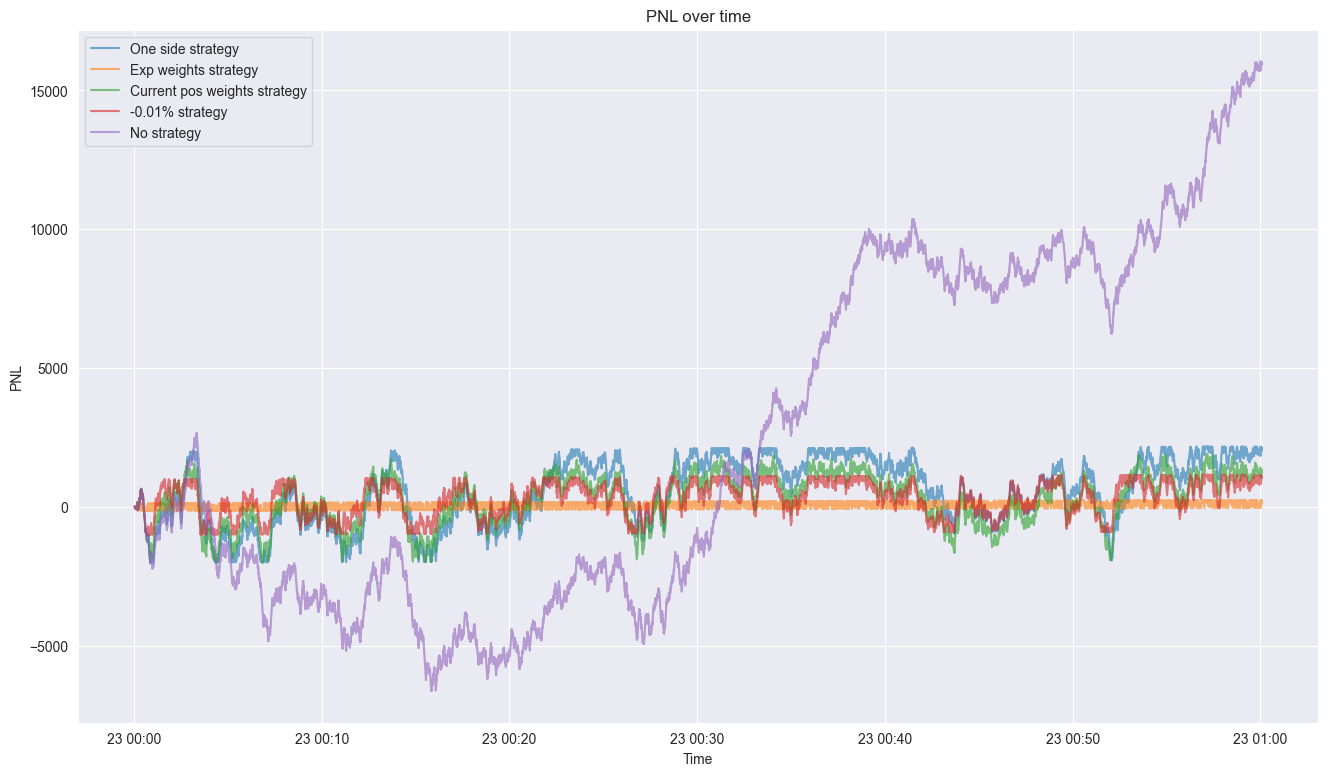

In [123]:
sns.set_style('darkgrid')
plt.figure(figsize=(16, 9))
plt.title('PNL over time')
plt.plot(one_side.history['time'], one_side.history['pnl'][1:], label='One side strategy', alpha=0.6)
plt.plot(exp_weights.history['time'], exp_weights.history['pnl'][1:], label='Exp weights strategy',
         alpha=0.6)
plt.plot(cur_weights.history['time'], cur_weights.history['pnl'][1:], label='Current pos weights strategy', alpha=0.6)

plt.plot(pos_perc.history['time'], pos_perc.history['pnl'][1:], label='-1% strategy',
         alpha=0.6)
plt.plot(no_liq.history['time'], no_liq.history['pnl'][1:], label='No strategy', alpha=0.6)
plt.legend()
plt.xlabel('Time')
plt.ylabel('PNL')

PnL с ликвидацией в среднем по модулю меньше, чем у стратегии без ликвидации. У стратегии с экспоненциальными весами PnL колеблется вокруг нуля.

Сравним inventory пяти стратегий:

Text(0, 0.5, 'Inventory')

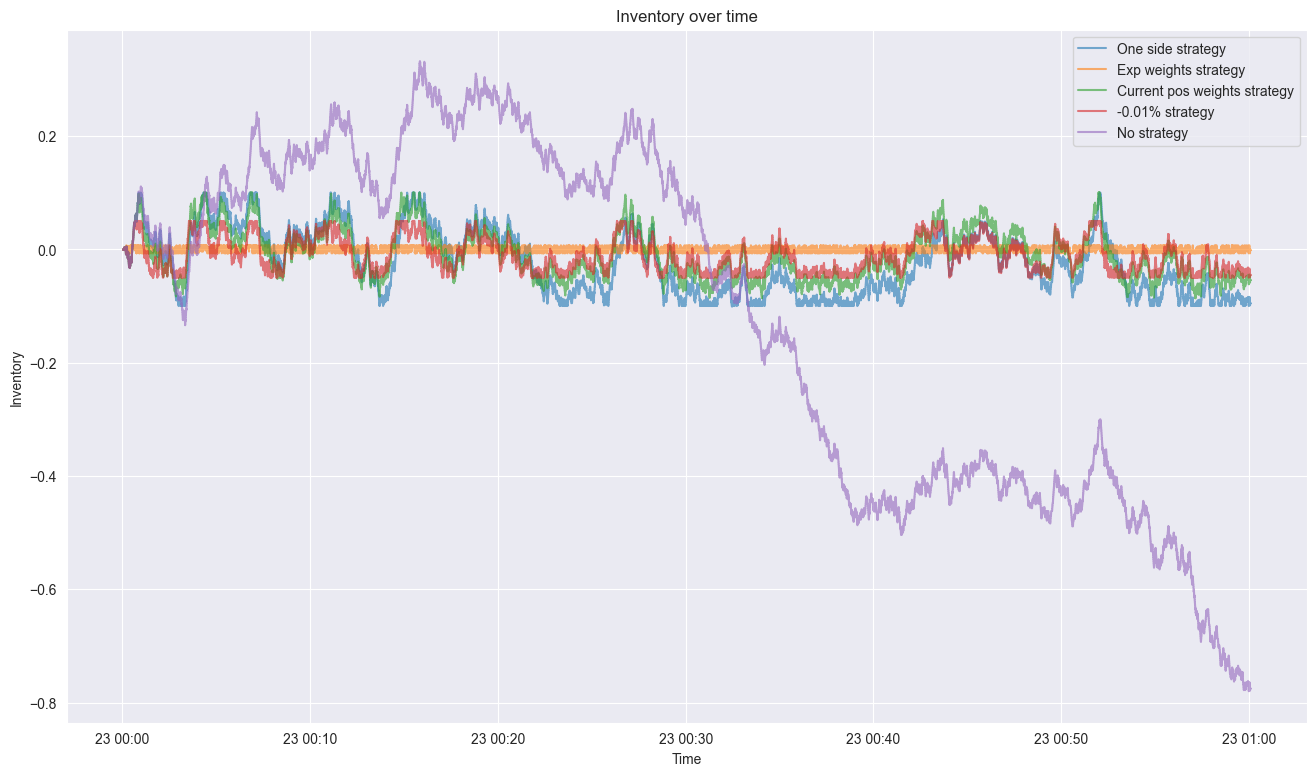

In [124]:
sns.set_style('darkgrid')
plt.figure(figsize=(16, 9))
plt.title('Inventory over time')
plt.plot(one_side.history['time'], one_side.history['inventory'], label='One side strategy', alpha=0.6)
plt.plot(exp_weights.history['time'], exp_weights.history['inventory'], label='Exp weights strategy',
         alpha=0.6)
plt.plot(cur_weights.history['time'], cur_weights.history['inventory'], label='Current pos weights strategy', alpha=0.6)

plt.plot(pos_perc.history['time'], pos_perc.history['inventory'], label='-1% strategy',
         alpha=0.6)
plt.plot(no_liq.history['time'], no_liq.history['inventory'], label='No strategy', alpha=0.6)
plt.legend()
plt.xlabel('Time')
plt.ylabel('Inventory')

Все наши методы ликвидации справляются с задачей ограничения позиции, при этом стратегия с экспоненциальными весами делает именно то, что нам нужно: держит позицию около нуля.

In [125]:
print('Стандартное отклонение Inventory:\nNo strategy: {}\nOne side strategy: {}\nExp weights strategy: {}\nCurrent position weights strategy: {}\n-0.01% strategy: {}'.format(np.std(no_liq.history['inventory'][1:]), np.std(one_side.history['inventory'][1:]), np.std(exp_weights.history['inventory'][1:]), np.std(cur_weights.history['inventory'][1:]), np.std(pos_perc.history['inventory'][1:])))

Стандартное отклонение Inventory:
No strategy: 0.27296838849879673
One side strategy: 0.06399773407259454
Exp weights strategy: 0.005136306913599122
Current position weights strategy: 0.04999396112831686
-0.01% strategy: 0.033416140017696556


Посмотрим на аналогичные графики без изначальной стратегии, чтобы они были более интерпретируемыми.

Text(0, 0.5, 'PNL')

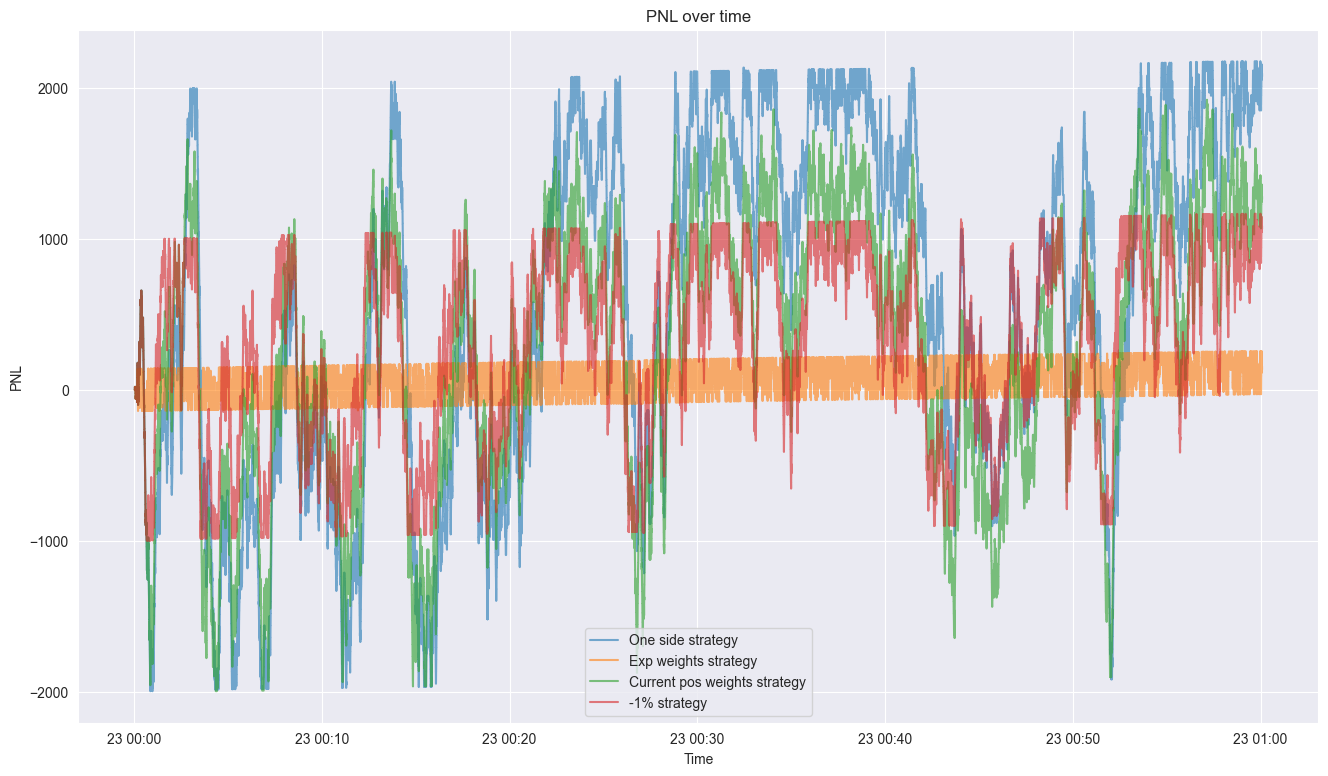

In [131]:
sns.set_style('darkgrid')
plt.figure(figsize=(16, 9))
plt.title('PNL over time')
plt.plot(one_side.history['time'], one_side.history['pnl'][1:], label='One side strategy', alpha=0.6)
plt.plot(exp_weights.history['time'], exp_weights.history['pnl'][1:], label='Exp weights strategy',
         alpha=0.6)
plt.plot(cur_weights.history['time'], cur_weights.history['pnl'][1:], label='Current pos weights strategy', alpha=0.6)

plt.plot(pos_perc.history['time'], pos_perc.history['pnl'][1:], label='-1% strategy',
         alpha=0.6)
plt.legend()
plt.xlabel('Time')
plt.ylabel('PNL')

Видно, что границы PnL'а растут линейно из-за отрицательной комиссии. Поэтому нам удалось даже извлечь прибыль с помощью экспоненциальной стратегии.

Text(0, 0.5, 'Inventory')

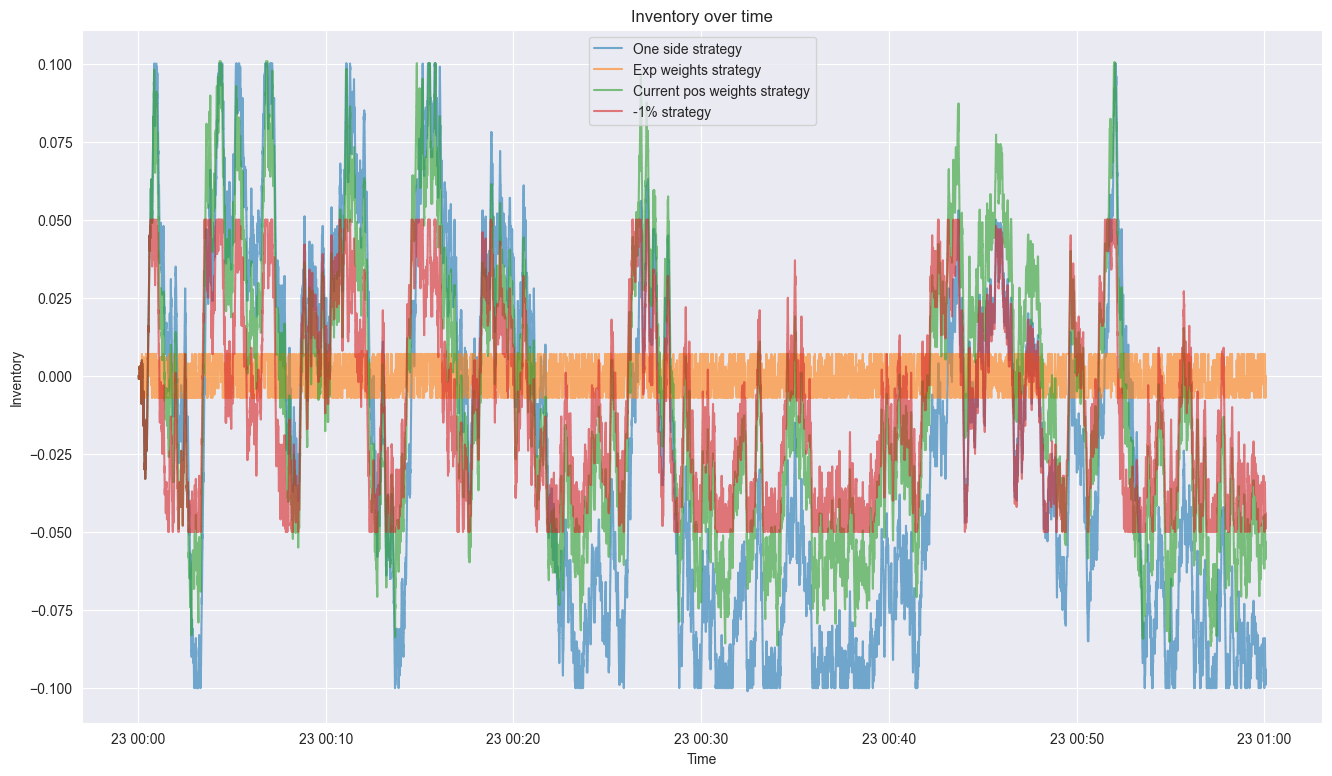

In [132]:
sns.set_style('darkgrid')
plt.figure(figsize=(16, 9))
plt.title('Inventory over time')
plt.plot(one_side.history['time'], one_side.history['inventory'], label='One side strategy', alpha=0.6)
plt.plot(exp_weights.history['time'], exp_weights.history['inventory'], label='Exp weights strategy',
         alpha=0.6)
plt.plot(cur_weights.history['time'], cur_weights.history['inventory'], label='Current pos weights strategy', alpha=0.6)

plt.plot(pos_perc.history['time'], pos_perc.history['inventory'], label='-1% strategy',
         alpha=0.6)
plt.legend()
plt.xlabel('Time')
plt.ylabel('Inventory')

Теперь попробуем менять цену в зависимости от объема позиции или выставлять маркетный ордер.

В первом подходе будем делать "скидку" 0.01% в нужную нам сторону.

In [5]:
sim = Sim(md, latency, md_latency)
sale_strategy = FutureMidPriceStrategy(delay, md, commission=-0.0001, price_strategy='sale')
res = sale_strategy.run(sim)

Во втором подходе будем использовать цену Стойкова.

In [25]:
sim = Sim(md, latency, md_latency)
stoikov_fut = FutureMidPriceStrategy(delay, md, commission=-0.0001, price_strategy='stoikov', gamma=1, intensity=3)
res = stoikov_fut.run(sim)

В третьем подходе будем сбрасывать всю позицию на каждом тике по маркетной цене (звучит бесполезно, но попробовать интересно).

In [9]:
sim = Sim(md, latency, md_latency)
market_drop = FutureMidPriceStrategy(delay, md, commission=-0.0001, market_strategy='all_pos')
res = market_drop.run(sim)

В четвертом подходе будем выставлять маркетный ордер размером 0.001

In [12]:
sim = Sim(md, latency, md_latency)
min_market = FutureMidPriceStrategy(delay, md, commission=-0.0001, market_strategy='min_trade')
res = min_market.run(sim)

Text(0, 0.5, 'PNL')

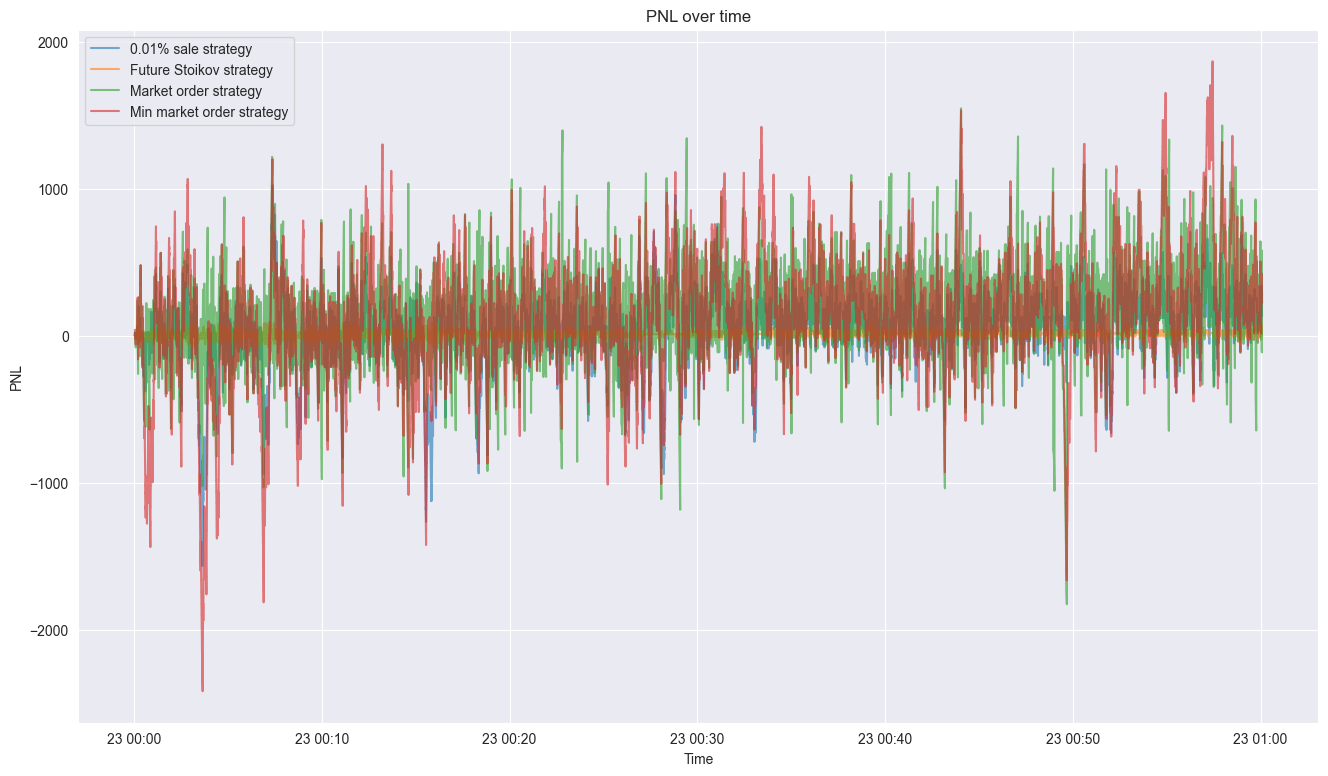

In [26]:
sns.set_style('darkgrid')
plt.figure(figsize=(16, 9))
plt.title('PNL over time')
plt.plot(sale_strategy.history['time'], sale_strategy.history['pnl'][1:], label='0.01% sale strategy', alpha=0.6)
plt.plot(stoikov_fut.history['time'], stoikov_fut.history['pnl'][1:], label='Future Stoikov strategy',
         alpha=0.6)
plt.plot(market_drop.history['time'], market_drop.history['pnl'][1:], label='Market order strategy', alpha=0.6)
# plt.plot(no_liq.history['time'], no_liq.history['pnl'][1:], label='No strategy', alpha=0.6)
plt.plot(min_market.history['time'], min_market.history['pnl'][1:], label='Min market order strategy', alpha=0.6)

plt.legend()
plt.xlabel('Time')
plt.ylabel('PNL')

Text(0, 0.5, 'Inventory')

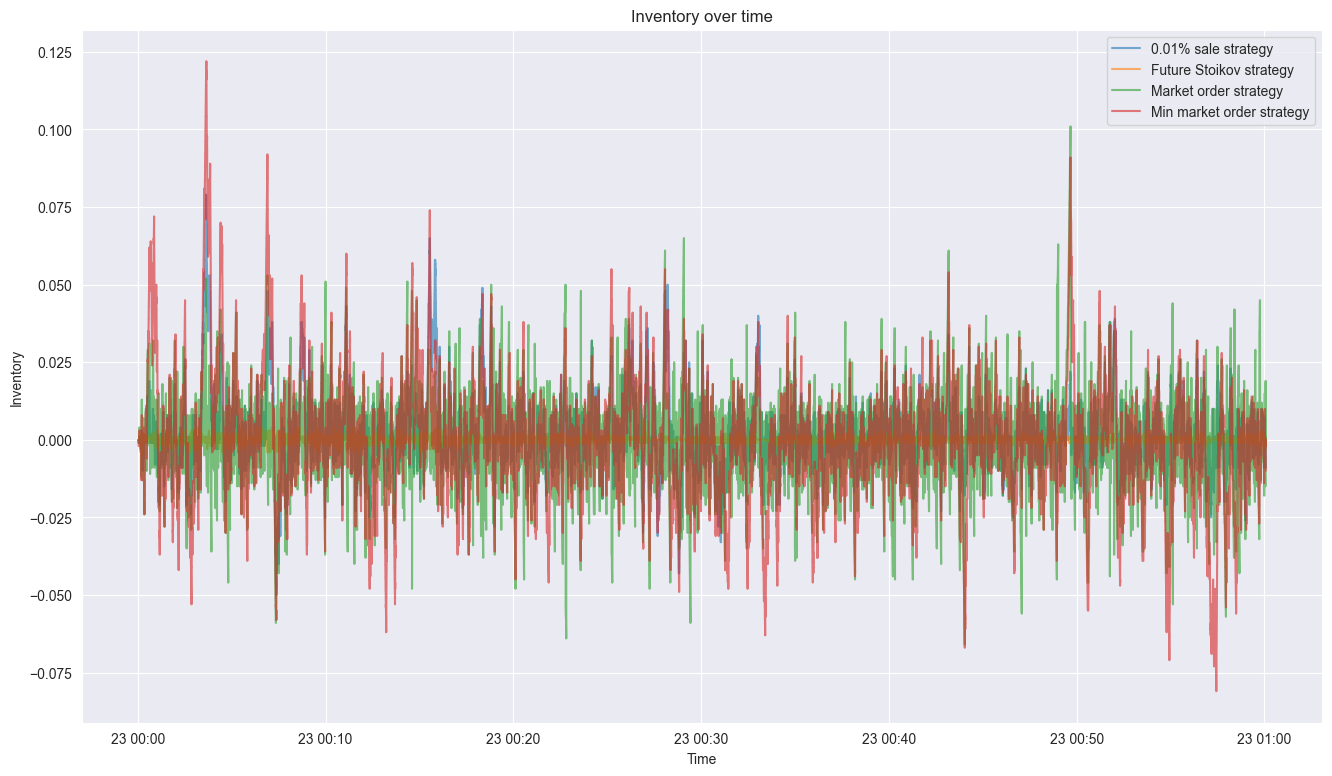

In [27]:
sns.set_style('darkgrid')
plt.figure(figsize=(16, 9))
plt.title('Inventory over time')

plt.plot(sale_strategy.history['time'], sale_strategy.history['inventory'], label='0.01% sale strategy', alpha=0.6)
plt.plot(stoikov_fut.history['time'], stoikov_fut.history['inventory'], label='Future Stoikov strategy',
         alpha=0.6)
# plt.plot(no_liq.history['time'], no_liq.history['inventory'], label='No strategy', alpha=0.6)
plt.plot(market_drop.history['time'], market_drop.history['inventory'], label='Market order strategy', alpha=0.6)
plt.plot(min_market.history['time'], min_market.history['inventory'], label='Min market order strategy', alpha=0.6)

plt.legend()
plt.xlabel('Time')
plt.ylabel('Inventory')

Построим графики по отдельности, потому что по построенным графикам особо сказать ничего нельзя, кроме того, что все стратегии держат позицию около нуля.

In [28]:
print('Стандартное отклонение Inventory:\nNo strategy: {}\nSale strategy: {}\nFuture Stoikov strategy: {}\nAll pos market order strategy: {}\nMin market order strategy: {}'.format(np.std(no_liq.history['inventory'][1:]), np.std(sale_strategy.history['inventory'][1:]), np.std(stoikov_fut.history['inventory'][1:]), np.std(market_drop.history['inventory'][1:]), np.std(min_market.history['inventory'][1:])))

Стандартное отклонение Inventory:
No strategy: 0.27296838849879673
Sale strategy: 0.01568049098458576
Future Stoikov strategy: 0.0010496780762226624
All pos market order strategy: 0.013556762748934614
Min market order strategy: 0.024743813983177092


C:\Users\Rs63\AppData\Local\Temp\ipykernel_1868\3529363303.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(221)


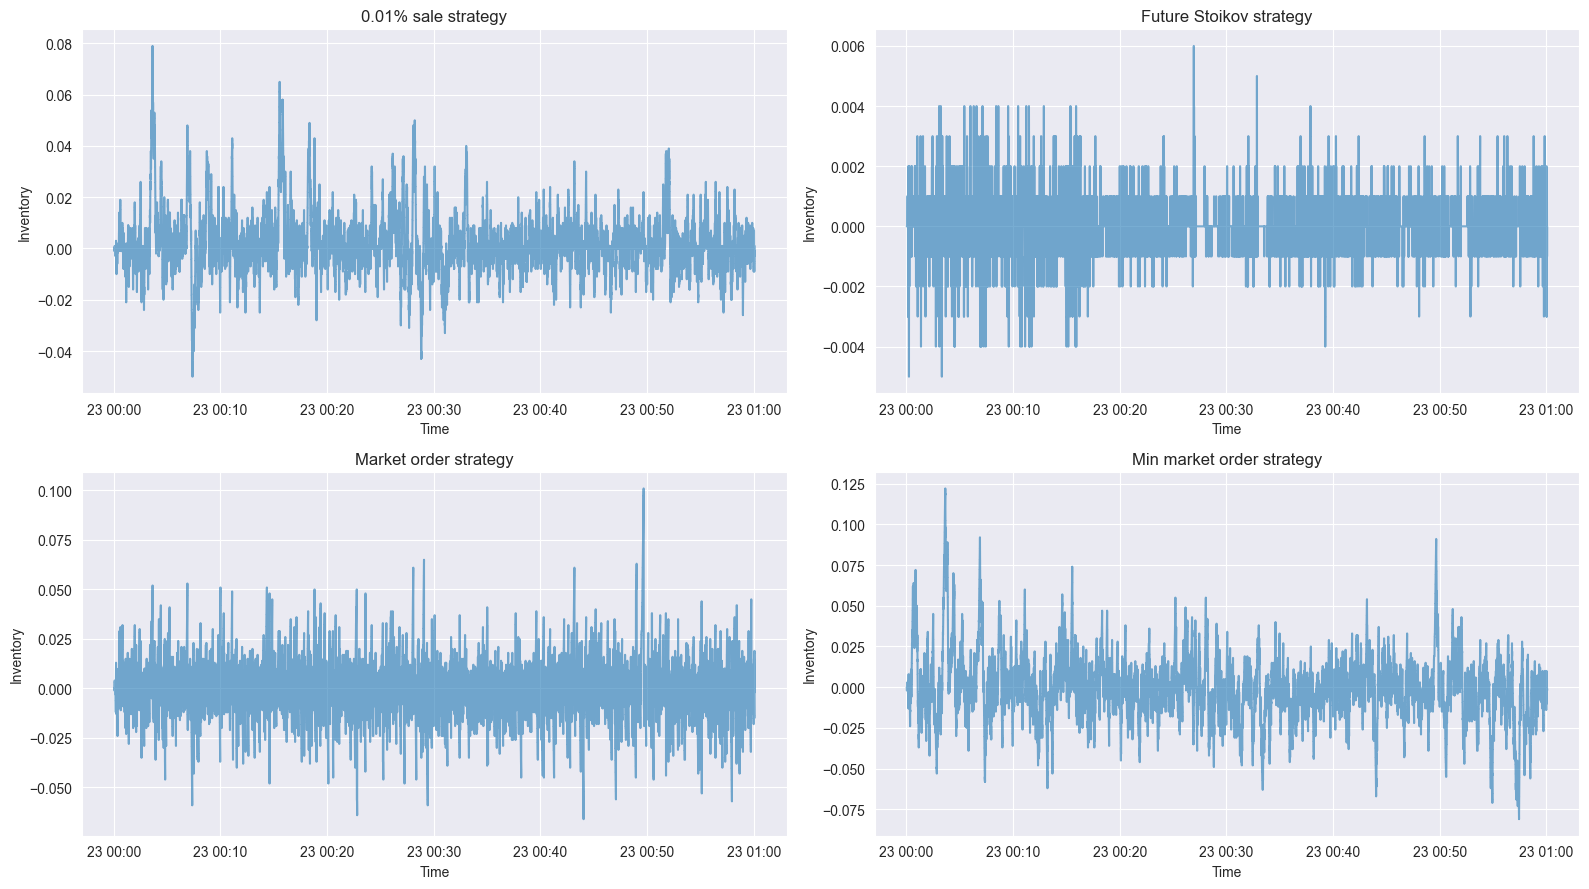

In [29]:
sns.set_style('darkgrid')
plt.figure(figsize=(16, 9))
plt.title('Inventory over time')

plt.subplot(221)
plt.plot(sale_strategy.history['time'], sale_strategy.history['inventory'], alpha=0.6)
plt.title('0.01% sale strategy')
plt.xlabel('Time')
plt.ylabel('Inventory')

plt.subplot(222)
plt.plot(stoikov_fut.history['time'], stoikov_fut.history['inventory'], alpha=0.6)
plt.xlabel('Time')
plt.ylabel('Inventory')
plt.title('Future Stoikov strategy')

plt.subplot(223)
plt.plot(market_drop.history['time'], market_drop.history['inventory'], alpha=0.6)
plt.xlabel('Time')
plt.ylabel('Inventory')
plt.title('Market order strategy')

plt.subplot(224)
plt.plot(min_market.history['time'], min_market.history['inventory'], alpha=0.6)
plt.xlabel('Time')
plt.ylabel('Inventory')
plt.title('Min market order strategy')

plt.tight_layout()

C:\Users\Rs63\AppData\Local\Temp\ipykernel_1868\1582754635.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(221)


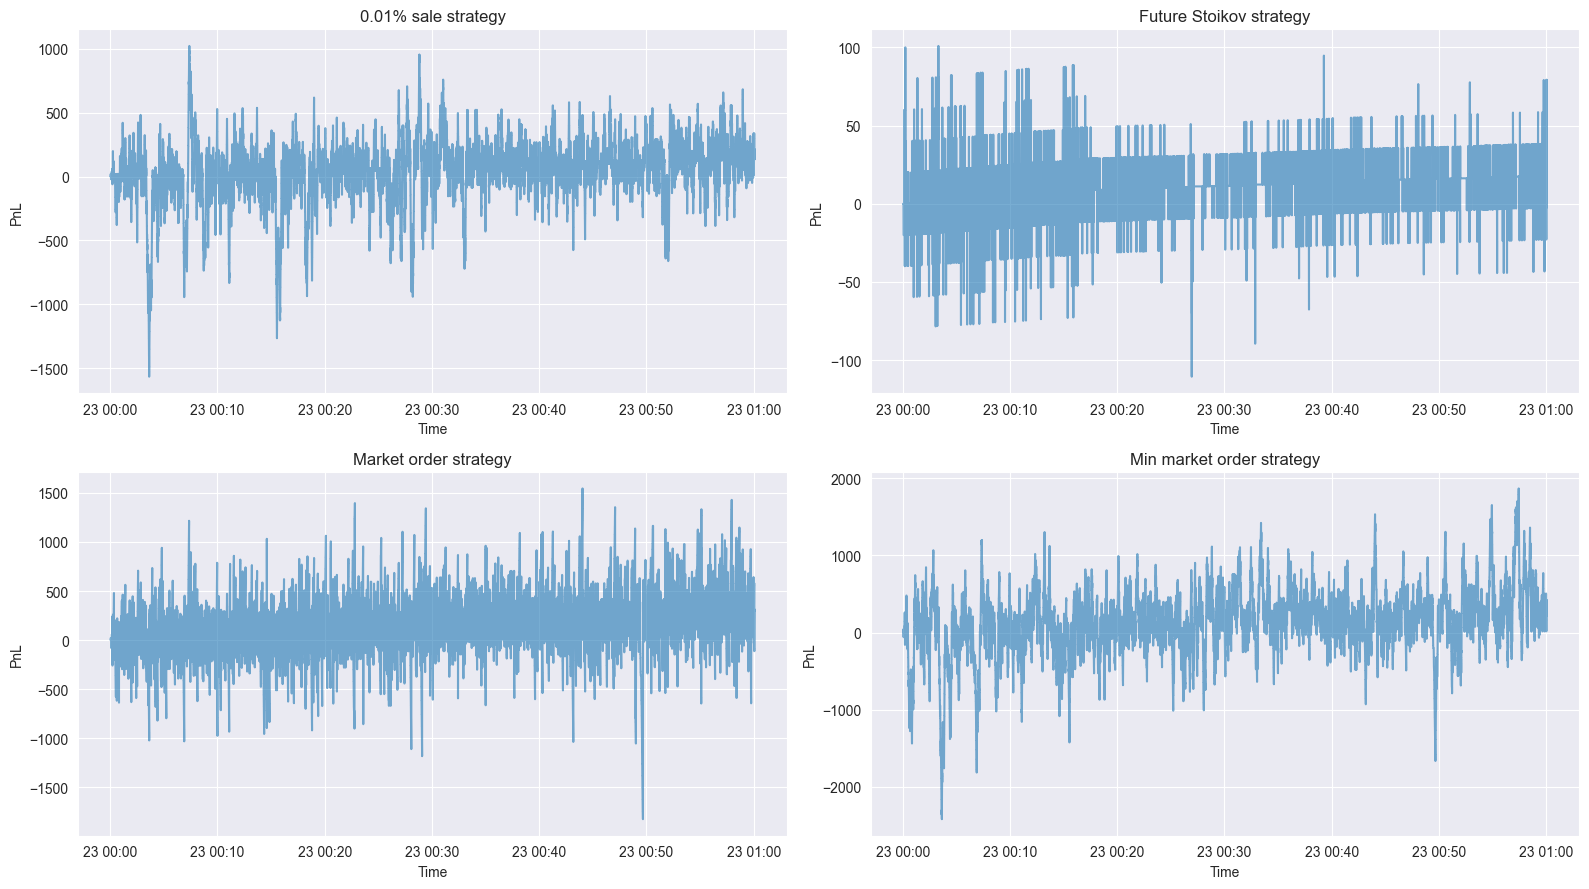

In [30]:
sns.set_style('darkgrid')
plt.figure(figsize=(16, 9))
plt.title('Inventory over time')

plt.subplot(221)
plt.plot(sale_strategy.history['time'], sale_strategy.history['pnl'][1:], alpha=0.6)
plt.title('0.01% sale strategy')
plt.xlabel('Time')
plt.ylabel('PnL')

plt.subplot(222)
plt.plot(stoikov_fut.history['time'], stoikov_fut.history['pnl'][1:], alpha=0.6)
plt.xlabel('Time')
plt.ylabel('PnL')
plt.title('Future Stoikov strategy')

plt.subplot(223)
plt.plot(market_drop.history['time'], market_drop.history['pnl'][1:], alpha=0.6)
plt.xlabel('Time')
plt.ylabel('PnL')
plt.title('Market order strategy')

plt.subplot(224)
plt.plot(min_market.history['time'], min_market.history['pnl'][1:], alpha=0.6)
plt.xlabel('Time')
plt.ylabel('PnL')
plt.title('Min market order strategy')

plt.tight_layout()

Благодаря отрицательной комиссии нам удалось получить положительный PnL. Все стратегии справились с поставленной задаче по удержанию позиции около нуля. Лучше всего по позиции оказалась стратегий Стойкова, а по PnL'у стратегии с маркетными ордерами, что ожидаемо, так как мы выставили отрицательную комиссию и с каждого маркетного ордера мы получали прибыль.